In [ ]:
import tensorflow as tf
from tensorflow import keras
import gdown
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from google.colab import drive
import math
from zipfile import ZipFile
from enum import Enum
from glob import glob
from functools import partial
import os
import random
!pip install tensorflow_addons
from tensorflow_addons.layers import InstanceNormalization
from google.colab import drive

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 6.6 MB/s eta 0:00:00


/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


Constants

In [ ]:
INTIAL_RES = 4
RESULT_RES = 128

Util functions for style GAN

In [ ]:
#reshape the image with resptive to reslution
def crop_img(res, data):
    data = tf.image.resize(
        data, (res, res), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR
    )
    data = tf.cast(data, tf.float32) / 127.5 - 1.0
    return data

#log conversion
def log2(x):
    return int(np.log2(x))

#Fadeing tht image
def blend(blend_param, x, y):
    return blend_param * x + (1.0 - blend_param) * y

In [ ]:
train_data = keras.utils.image_dataset_from_directory(
    "/content/drive/MyDrive/face", label_mode=None, image_size=(64, 64), batch_size=32
)

Found 1000 files belonging to 1 classes.


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Mapping Network creation

In [ ]:
def Mapping(num_blocks, input_shape=512):
      l = layers.Input(shape=(input_shape))
      w = l / tf.math.sqrt(tf.reduce_mean(l ** 2, axis=-1, keepdims=True) + 1e-8)
      for i in range(8):
          w = CustomDense(512, learning_rate_multiplier=0.01)(w)
          w = layers.LeakyReLU(0.2)(w)
      w = tf.tile(tf.expand_dims(w, 1), (1, num_blocks, 1))
      return keras.Model(l, w, name="mapping")

The custom nose layer neural network.

In [ ]:
class GenNoise(layers.Layer):
    def build(self, input_shape):
        n, h, w, c = input_shape[0]
        inta = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.b = self.add_weight(
            shape=[1, 1, 1, c], initializer=inta, trainable=True, name="kernel"
        )

    def call(self, inputs):
        a, rnd = inputs
        reslt = a + self.b * rnd
        return reslt

custom dense layer where the standard devotion of all weights falls from 0 to 1

In [ ]:
class CustomDense(layers.Layer):
    def __init__(self, units, gain=2, learning_rate_multiplier=1, **kwargs):
        super().__init__(**kwargs)
        self.units = units
        self.gain = gain
        self.learning_rate_multiplier = learning_rate_multiplier

    def build(self, input_shape):
        self.in_channels = input_shape[-1]
        inta = keras.initializers.RandomNormal(
            mean=0.0, stddev=1.0 / self.learning_rate_multiplier
        )
        self.w = self.add_weight(
            shape=[self.in_channels, self.units],
            initializer=inta,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.units,), initializer="zeros", trainable=True, name="bias"
        )
        blnd = self.in_channels
        self.scale = tf.sqrt(self.gain / blnd)

    def call(self, inputs):
        rslt = tf.add(tf.matmul(inputs, self.scale * self.w), self.b)
        return rslt * self.learning_rate_multiplier

Learned affine transformations then specialize [the intermediate latent vector] to styles y = (ys, yb) that control adaptive instance normalization (AdaIN) operations after each convolution layer of the synthesis network g.

In [ ]:
class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super().__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_dim = input_shapes[0]
        w_dim = input_shapes[1]

        self.w_channels = w_dim[-1]
        self.x_channels = x_dim[-1]

        self.dense_1 = CustomDense(self.x_channels, gain=1)
        self.dense_2 = CustomDense(self.x_channels, gain=1)

    def call(self, inputs):
        a, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * a + yb

The adaptive Instance Normalization layer is used to adjust the style of an input feature map (x) based on the style parameters.

In [ ]:
class AdaIN(layers.Layer):
    def __init__(self, gain=1, **kwargs):
        super().__init__(**kwargs)
        self.gain = gain

    def build(self, input_shapes):
        x_dim = input_shapes[0]
        w_dim = input_shapes[1]

        self.w_channels = w_dim[-1]
        self.x_channels = x_dim[-1]

        self.dense_1 = CustomDense(self.x_channels, gain=1)
        self.dense_2 = CustomDense(self.x_channels, gain=1)

    def call(self, inputs):
        a, w = inputs
        ys = tf.reshape(self.dense_1(w), (-1, 1, 1, self.x_channels))
        yb = tf.reshape(self.dense_2(w), (-1, 1, 1, self.x_channels))
        return ys * a + yb

a custom convolution layer where the standard devotion of all weights ititalise from 0 to 1

In [ ]:
class CustomConv(layers.Layer):
    def __init__(self, chanls_rslt, kernl=3, gain=2, **kwargs):
        super().__init__(**kwargs)
        self.kernl = kernl
        self.chanls_rslt = chanls_rslt
        self.gain = gain
        self.pad = kernl != 1

    def build(self, input_shape):
        self.chnls_in = input_shape[-1]
        int = keras.initializers.RandomNormal(mean=0.0, stddev=1.0)
        self.w = self.add_weight(
            shape=[self.kernl, self.kernl, self.chnls_in, self.chanls_rslt],
            initializer=int,
            trainable=True,
            name="kernel",
        )
        self.b = self.add_weight(
            shape=(self.chanls_rslt,), initializer="zeros", trainable=True, name="bias"
        )
        blnd = self.kernl * self.kernl * self.chnls_in
        self.scale = tf.sqrt(self.gain / blnd)

    def call(self, inputs):
        if self.pad:
          k = tf.pad(inputs, [[0, 0], [1, 1], [1, 1], [0, 0]], mode="REFLECT")
        else:
          k = inputs
        reslt = (
            tf.nn.conv2d(k, self.scale * self.w, strides=1, padding="VALID") + self.b)
        return reslt

Generator The discriminator block is applied from lower resolution to hihger resolution.

In [ ]:
class Generator:
    def __init__(self, intial_res, final_res_log2):
        self.intial_res = intial_res
        self.noise_inputs = []
        self.num_blocks = final_res_log2 - intial_res + 1
        self.gen_bloks = []
        self.to_clr = []
        self.final_res_log2 = final_res_log2
        self.fltr_vals = {0: 512, 1: 512, 2: 512, 3: 512, 4: 512, 5: 512, 6: 256, 7: 128, 8: 64, 9: 32, 10: 16,}

        start_resval = 2 ** intial_res
        self.input_shape = (start_resval, start_resval, self.fltr_vals[intial_res])
        self.g_input = layers.Input(self.input_shape, name="generator_input")
        for k in range(intial_res, final_res_log2 + 1):
            filter_num = self.fltr_vals[k]
            res = 2 ** k
            self.noise_inputs.append(
                layers.Input(shape=(res, res, 1), name=f"noise_{res}x{res}")
            )
            to_clr = Sequential(
                [
                    layers.InputLayer(input_shape=(res, res, filter_num)),
                    CustomConv(3, 1, gain=1),
                ],
                name=f"to_rgb_{res}x{res}",
            )
            self.to_clr.append(to_clr)
            first_res = k == self.intial_res
            if first_res:
                input_shape = (res, res, self.fltr_vals[k - 1])
            else:
                input_shape = (2 ** (k - 1), 2 ** (k - 1), self.fltr_vals[k - 1])
            g_block = self.genrt_blocks(
                filter_num, res=res, input_shape=input_shape, first_res=first_res
            )
            self.gen_bloks.append(g_block)
   #Genartion of blocks based on the reslution
    def genrt_blocks(self, filter_num, res, input_shape, first_res):
        input_tensor = layers.Input(shape=input_shape, name=f"g_{res}")
        noise = layers.Input(shape=(res, res, 1), name=f"noise_{res}")
        w = layers.Input(shape=512)
        x = input_tensor

        if not first_res:
            x = layers.UpSampling2D((2, 2))(x)
            x = CustomConv(filter_num, 3)(x)

        x = GenNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])

        x = CustomConv(filter_num, 3)(x)
        x = GenNoise()([x, noise])
        x = layers.LeakyReLU(0.2)(x)
        x = InstanceNormalization()(x)
        x = AdaIN()([x, w])
        return keras.Model([input_tensor, w, noise], x, name=f"genblock_{res}x{res}")
   #The generator will grow with respective to resolution.
    def add_blocks(self, res_log2):
        res = 2 ** res_log2

        num_blocks = res_log2 - self.intial_res + 1
        w = layers.Input(shape=(self.num_blocks, 512), name="w")

        blend_param = layers.Input(shape=(1), name="g_alpha")
        x = self.gen_bloks[0]([self.g_input, w[:, 0], self.noise_inputs[0]])

        if num_blocks == 1:
            colr = self.to_clr[0](x)
        else:
            for k in range(1, num_blocks - 1):

                x = self.gen_bloks[k]([x, w[:, k], self.noise_inputs[k]])

            old_colr = self.to_clr[num_blocks - 2](x)
            old_colr = layers.UpSampling2D((2, 2))(old_colr)

            k = num_blocks - 1
            x = self.gen_bloks[k]([x, w[:, k], self.noise_inputs[k]])

            new_colr = self.to_clr[k](x)

            colr = blend(blend_param[0], new_colr, old_colr)

        return keras.Model(
            [self.g_input, w, self.noise_inputs, blend_param],
            colr,
            name=f"generator_{res}_x_{res}",
        )

Descrimator The discriminator block is applied from higher resolution to lower resolution.

In [ ]:
class Discriminator:
    def __init__(self, intial_res, final_res_log2):
        self.intial_res = intial_res
        self.final_res_log2 = final_res_log2
        self.num_blocks = final_res_log2 - intial_res + 1
        self.fltr_vals = {0: 512, 1: 512, 2: 512, 3: 512, 4: 512, 5: 512, 6: 256, 7: 128, 8: 64, 9: 32, 10: 16,}
        self.d_blocks = []
        self.from_rgb = []

        for res_log2 in range(self.intial_res, self.final_res_log2 + 1):
            res = 2 ** res_log2
            filter_num = self.fltr_vals[res_log2]
            from_rgb = Sequential(
                [
                    layers.InputLayer(
                        input_shape=(res, res, 3), name=f"from_rgb_input_{res}"
                    ),
                    CustomConv(filter_num, 1),
                    layers.LeakyReLU(0.2),
                ],
                name=f"from_rgb_{res}",
            )

            self.from_rgb.append(from_rgb)

            input_shape = (res, res, filter_num)
            if len(self.d_blocks) == 0:
                d_block = self.build_base(filter_num, res)
            else:
                d_block = self.genrt_blocks(
                    filter_num, self.fltr_vals[res_log2 - 1], res
                )

            self.d_blocks.append(d_block)
    #Genartion of Discriminator for base blocks based on the reslution
    def build_base(self, filter_num, res):
        input_tensor = layers.Input(shape=(res, res, filter_num), name=f"d_{res}")

        n, h, w, c = tf.shape(input_tensor)
        set_size = tf.minimum(4, n)
        set_mean, group_var = tf.nn.moments(tf.reshape(input_tensor, [set_size, -1, h, w, c]), axes=(0), keepdims=False)
        set_std = tf.sqrt(group_var + 1e-8)
        x = tf.concat([input_tensor, tf.tile(tf.reduce_mean(set_std, axis=[1, 2, 3], keepdims=True), [set_size, h, w, 1])], axis=-1)
        x = CustomConv(filter_num, 3)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.Flatten()(x)
        x = CustomDense(filter_num)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = CustomDense(1)(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")
    #Genartion of blocks based on the reslution
    def genrt_blocks(self, filter_num_1, filter_num_2, res):
        input_tensor = layers.Input(shape=(res, res, filter_num_1), name=f"d_{res}")
        x = CustomConv(filter_num_1, 3)(input_tensor)
        x = layers.LeakyReLU(0.2)(x)
        x = CustomConv(filter_num_2)(x)
        x = layers.LeakyReLU(0.2)(x)
        x = layers.AveragePooling2D((2, 2))(x)
        return keras.Model(input_tensor, x, name=f"d_{res}")

    #The descrimainator will grow with respective to resolution.
    def add_blocks(self, res_log2):
        res = 2 ** res_log2
        idx = res_log2 - self.intial_res
        blend_param = layers.Input(shape=(1), name="d_alpha")
        input_image = layers.Input(shape=(res, res, 3), name="input_image")
        x = self.from_rgb[idx](input_image)
        x = self.d_blocks[idx](x)
        if idx > 0:
            idx -= 1
            downsized_image = layers.AveragePooling2D((2, 2))(input_image)
            y = self.from_rgb[idx](downsized_image)
            x = blend(blend_param[0], x, y)

            for i in range(idx, -1, -1):
                x = self.d_blocks[i](x)
        return keras.Model([input_image, blend_param], x, name=f"discriminator_{res}_x_{res}")


StyleGAN It is responsible for growing discriminators and generators with respect to the target resolution.

In [ ]:
def wasserstein_loss(y_true, y_pred):
    return -tf.reduce_mean(y_true * y_pred)

class StyleGAN(tf.keras.Model):
    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super().__init__()

    def __init__(self, z_dim=512, target_res=64, start_res=4):
        super().__init__()
        self.intial_res = log2(start_res)
        self.blend_param = tf.Variable(1.0, dtype=tf.float32, trainable=False, name="blend_param")
        self.final_res_log2 = log2(target_res)
        self.des_builder = Discriminator(self.intial_res, self.final_res_log2)
        self.z_dim = z_dim
        self.mode = None
        self.train_step_counter = tf.Variable(0, dtype=tf.int32, trainable=False)
        self.num_blocks = self.final_res_log2 - self.intial_res + 1
        self.loss_weights = {"gradient_penalty": 10, "drift": 0.001}
        self.gen_builder = Generator(self.intial_res, self.final_res_log2)
        self.g_input_shape = self.gen_builder.input_shape
        self.current_res_log2 = self.final_res_log2
        self.mapping = Mapping(num_blocks=self.num_blocks)

    def add_model(self, res):
        tf.keras.backend.clear_session()
        res_log2 = log2(res)
        self.gen_model = self.gen_builder.add_blocks(res_log2)
        self.desc_model = self.des_builder.add_blocks(res_log2)
        self.current_res_log2 = res_log2
        print(f"\nModel resolution:{res}x{res}")

    def compile(
        self, steps_per_epoch, mode, res, d_optimizer, g_optimizer, *args, **kwargs
    ):
        self.loss_weights = kwargs.pop("loss_weights", self.loss_weights)
        self.steps_per_epoch = steps_per_epoch
        if res != 2 ** self.current_res_log2:
            self.add_model(res)
            self.d_optimizer = d_optimizer
            self.g_optimizer = g_optimizer

        self.train_step_counter.assign(0)
        self.mode = mode
        self.disc_loss = keras.metrics.Mean(name="d_loss")
        self.gen_loss = keras.metrics.Mean(name="g_loss")
        super().compile(*args, **kwargs)

    @property
    def metrics(self):
        return [self.disc_loss, self.gen_loss]

    def generate_noise(self, bat_size):
        noise = [
            tf.random.normal((bat_size, 2 ** res, 2 ** res, 1))
            for res in range(self.intial_res, self.final_res_log2 + 1)
        ]
        return noise

    def cal_gradient_loss(self, grad):
        loss = tf.square(grad)
        loss = tf.reduce_sum(loss, axis=tf.range(1, tf.size(tf.shape(loss))))
        loss = tf.sqrt(loss)
        loss = tf.reduce_mean(tf.square(loss - 1))
        return loss

    def train_step(self, real_images):
        batch_size = tf.shape(real_images)[0]
        real_labl = tf.ones(batch_size)
        fake_label = -tf.ones(batch_size)
        z = tf.random.normal((batch_size, self.z_dim))
        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        noise = self.generate_noise(batch_size)

        self.train_step_counter.assign_add(1)

        if self.mode == "TRANSITION":
            self.blend_param.assign(
                tf.cast(self.train_step_counter / self.steps_per_epoch, tf.float32)
            )
        elif self.mode == "STABLE":
            self.blend_param.assign(1.0)
        else:
            raise NotImplementedError
        blend_param = tf.expand_dims(self.blend_param, 0)

        #gan_model
        with tf.GradientTape() as gen_tape:
            w = self.mapping(z)
            fake_faces = self.gen_model([const_input, w, noise, blend_param])
            pred_fake = self.desc_model([fake_faces, blend_param])
            g_loss = wasserstein_loss(real_labl, pred_fake)

            trainable_weights = (
                self.mapping.trainable_weights + self.gen_model.trainable_weights
            )
            gradient = gen_tape.gradient(g_loss, trainable_weights)
            self.g_optimizer.apply_gradients(zip(gradient, trainable_weights))

        # desc_model
        with tf.GradientTape() as gradient_tape, tf.GradientTape() as total_tape:

            epsilon = tf.random.uniform((batch_size, 1, 1, 1))
            inter = epsilon * real_images + (1 - epsilon) * fake_portraits
            gradient_tape.watch(inter)
            pred_fake_grad = self.desc_model([inter, blend_param])

            pred_real = self.desc_model([real_images, blend_param])
            pred_fake = self.desc_model([fake_portraits, blend_param])
            # calculate losses
            loss_fake = wasserstein_loss(fake_label, pred_fake)
            loss_real = wasserstein_loss(real_labl, pred_real)
            loss_fake_grad = wasserstein_loss(fake_label, pred_fake_grad)

            # gradient penalty
            gradient_penalty = self.loss_weights[
                "gradient_penalty"
            ] * self.cal_gradient_loss(gradient_tape.gradient(loss_fake_grad, [inter]))



            drift_loss = self.loss_weights["drift"] * tf.reduce_mean(tf.concat([pred_fake, pred_real], axis=0) ** 2)

            d_loss = loss_fake + loss_real + gradient_penalty + drift_loss

            gradient = total_tape.gradient(
                d_loss, self.desc_model.trainable_weights
            )
            self.d_optimizer.apply_gradients(
                zip(gradient, self.desc_model.trainable_weights)
            )

        # Update metrics
        self.disc_loss.update_state(d_loss)
        self.gen_loss.update_state(g_loss)
        return {
            "d_loss": self.disc_loss.result(),
            "g_loss": self.gen_loss.result(),
        }

    def call(self, inputs: dict()):
        style_code = inputs.get("style_code", None)
        z = inputs.get("z", None)
        noise = inputs.get("noise", None)
        batch_size = inputs.get("batch_size", 1)
        blend_param = inputs.get("blend_param", 1.0)
        blend_param = tf.expand_dims(blend_param, 0)
        if style_code is None:
            if z is None:
                z = tf.random.normal((batch_size, self.z_dim))
            style_code = self.mapping(z)

        if noise is None:
            noise = self.generate_noise(batch_size)

        # self.blend_param.assign(blend_param)

        const_input = tf.ones(tuple([batch_size] + list(self.g_input_shape)))
        images = self.gen_model([const_input, style_code, noise, blend_param])
        images = np.clip((images * 0.5 + 0.5) * 255, 0, 255).astype(np.uint8)

        return images

In [ ]:
styleGan = StyleGAN(start_res=INTIAL_RES, target_res=RESULT_RES)
res_bth_sz = {2: 16, 3: 16, 4: 16, 5: 16, 6: 16, 7: 8, 8: 4, 9: 2, 10: 1}
no_train_stps = {f: res_bth_sz[2] / d for f, d in res_bth_sz.items()}

In [ ]:
#image ploting
def result_plt(portrats, power_vl, fname="/content/drive/MyDrive/images"):
    measures = {2: 0.5, 3: 1, 4: 2, 5: 3, 6: 4, 7: 5, 8: 6, 9: 7, 10: 8}
    scales = measures[power_vl]
    no_cl = min(portrats.shape[0], int(32 // scales))
    no_rw = 1
    f, axarr = plt.subplots(
        no_rw, no_cl, figsize=(no_cl * scales, no_rw * scales)
    )
    for i in range(no_rw):
        axi = axarr if no_rw == 1 else axarr[i]
        for k in range(no_cl):
            axi[k].imshow(portrats[i * no_cl + k])
            axi[k].axis("off")
    plt.show()
    if fname:
        f.savefig(fname)

In [ ]:
def train(
    start_res=INTIAL_RES,
    target_res=RESULT_RES,
    steps_per_epoch=5000,
    display_images=True,
):
    #hyper parameter configuraion
    optimizer_config = {"learning_rate": 1e-3, "beta_1": 0.0, "beta_2": 0.99, "epsilon": 1e-8}

    intial_res = int(np.log2(start_res))
    final_res_log2 = int(np.log2(target_res))
    #in transitonla face the imges abuilt on the resluion
    #in stalble face the imgaes will go throgh fade in process vary with the blend parmeter
    for res_log2 in range(intial_res, final_res_log2 + 1):
        res = 2 ** res_log2
        for mode in ["TRANSITION", "STABLE"]:
            if res == start_res and mode == "TRANSITION":
                continue

            train_dl = train_data.map(partial(crop_img, res), num_parallel_calls=tf.data.AUTOTUNE).unbatch()

            styleGan.compile(
                d_optimizer=tf.keras.optimizers.legacy.Adam(**optimizer_config),
                g_optimizer=tf.keras.optimizers.legacy.Adam(**optimizer_config),
                loss_weights={"gradient_penalty": 9, "drift": 0.002},
                steps_per_epoch=int(no_train_stps[res_log2] * steps_per_epoch),
                res=res,
                mode=mode,
                run_eagerly=False,
            )

            prefix = f"res_{res}x{res}_{styleGan.mode}"

            ckpt_cb = keras.callbacks.ModelCheckpoint(
                f"/content/drive/MyDrive/checkpoints/stylegan_{res}x{res}.ckpt",
                save_weights_only=True,
                verbose=0,
            )
            print(mode)
            styleGan.fit(
                train_dl.shuffle(250).batch(res_bth_sz[log2(res)], drop_remainder=True).prefetch(1).repeat()
				, epochs=1, steps_per_epoch=int(no_train_stps[res_log2] * steps_per_epoch), callbacks=[ckpt_cb]
            )

            images = styleGan({"z": tf.random.normal((16, styleGan.z_dim)), "noise": styleGan.generate_noise(16), "blend_param": 1.0})
            result_plt(images, res_log2)


Model resolution:4x4
STABLE
5000/5000 [==============================] - 268s 47ms/step - d_loss: -4.5660 - g_loss: 3.0761


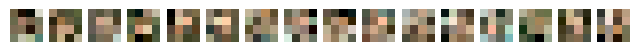


Model resolution:8x8
TRANSITION
5000/5000 [==============================] - 463s 91ms/step - d_loss: -4.3405 - g_loss: 3.0813


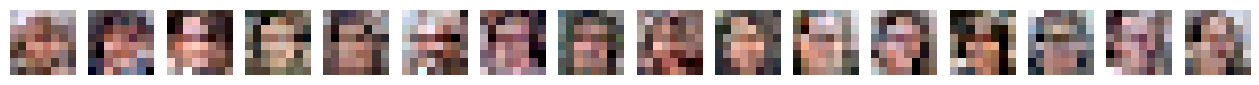

STABLE
5000/5000 [==============================] - 459s 91ms/step - d_loss: -3.3651 - g_loss: 2.3363


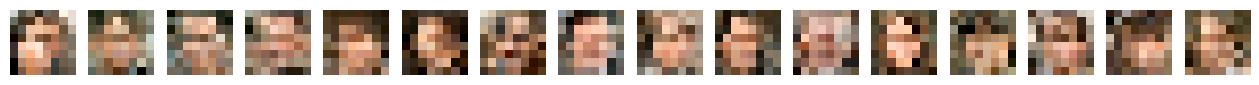


Model resolution:16x16
TRANSITION
5000/5000 [==============================] - 985s 196ms/step - d_loss: -5.0096 - g_loss: 4.0706


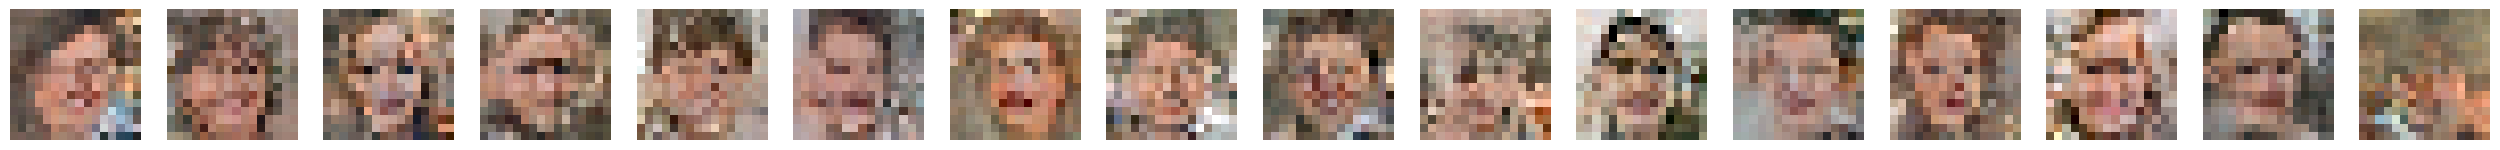

STABLE
5000/5000 [==============================] - 981s 195ms/step - d_loss: -3.5878 - g_loss: 2.7001


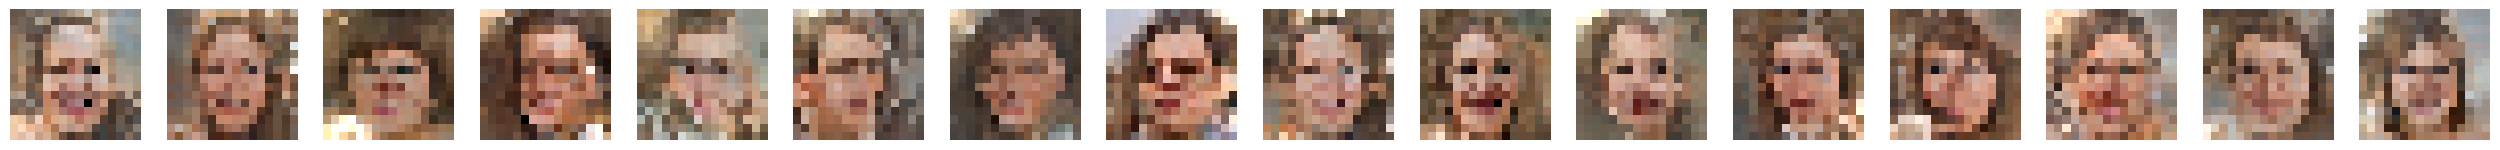


Model resolution:32x32
TRANSITION
5000/5000 [==============================] - 2515s 501ms/step - d_loss: -7.8018 - g_loss: 5.9122


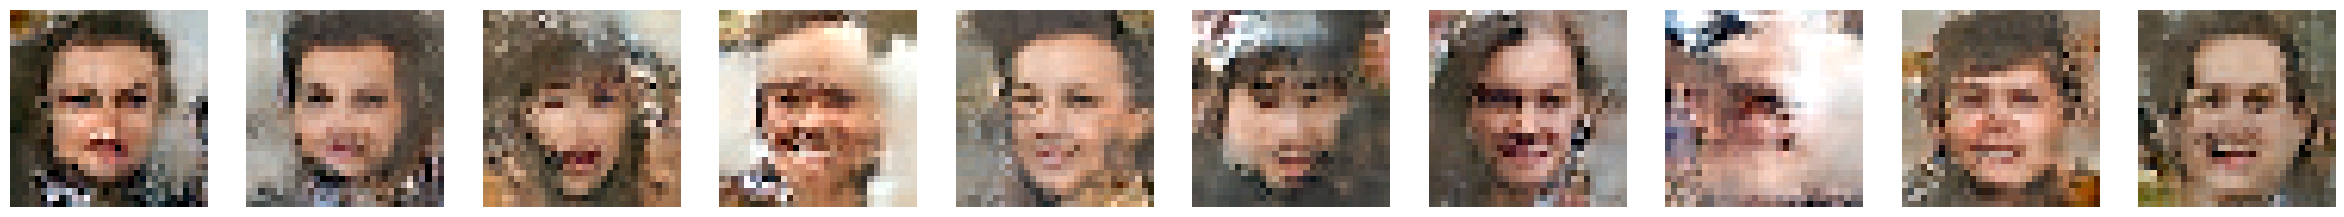

STABLE
5000/5000 [==============================] - 2511s 501ms/step - d_loss: -7.8964 - g_loss: 5.6499


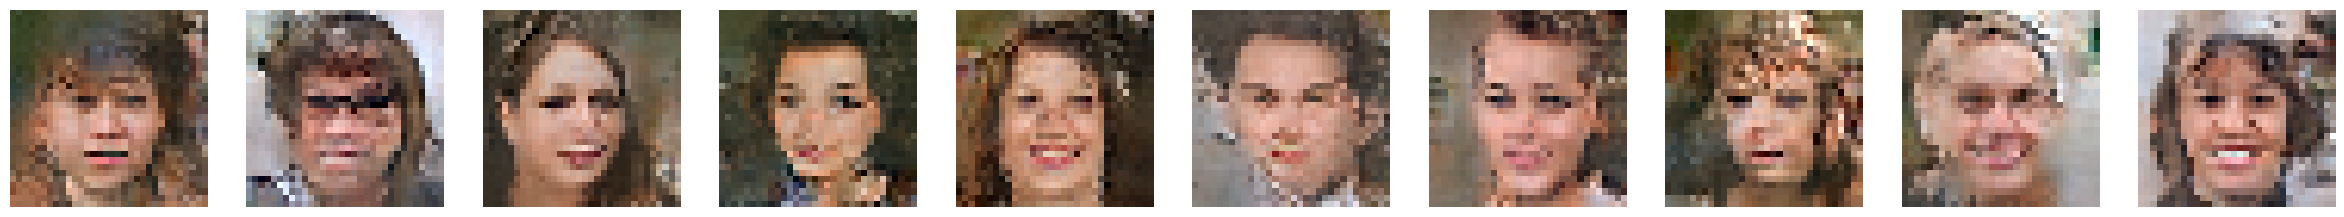


Model resolution:64x64
TRANSITION
5000/5000 [==============================] - 5199s 1s/step - d_loss: -17.7234 - g_loss: 13.0625


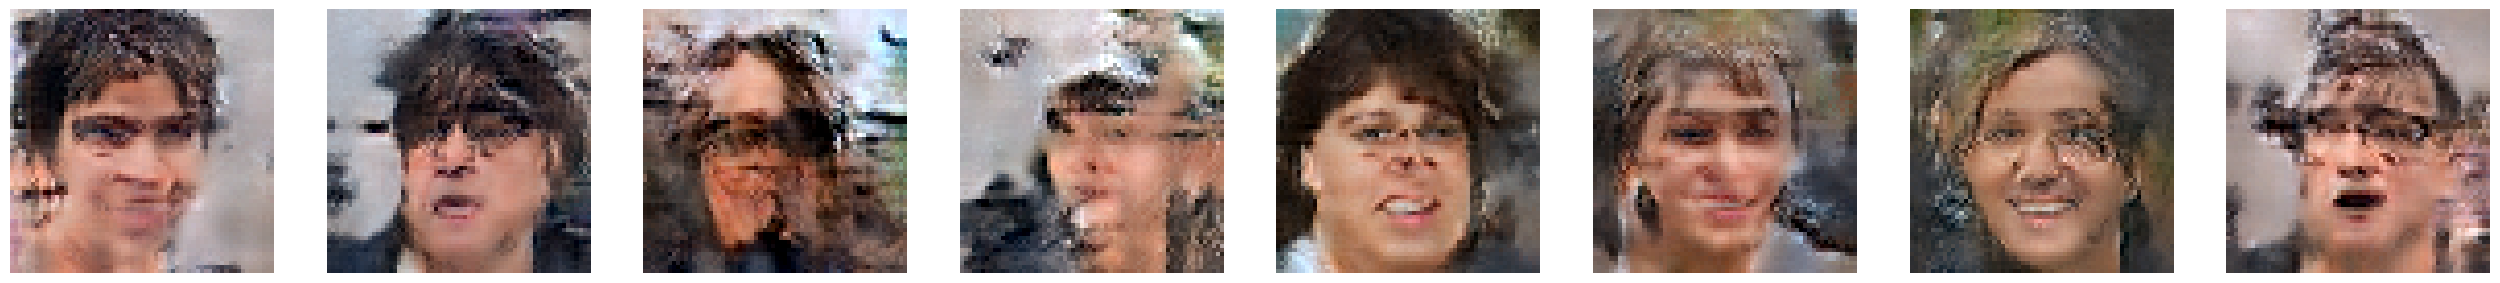

STABLE
 332/5000 [>.............................] - ETA: 1:20:42 - d_loss: -19.5616 - g_loss: 14.2756

In [ ]:
train(start_res=4, target_res=128, steps_per_epoch=5000, display_images=True)

Mix two style vectors using linear interpolation


Model resolution:64x64


(-0.5, 191.5, 63.5, -0.5)

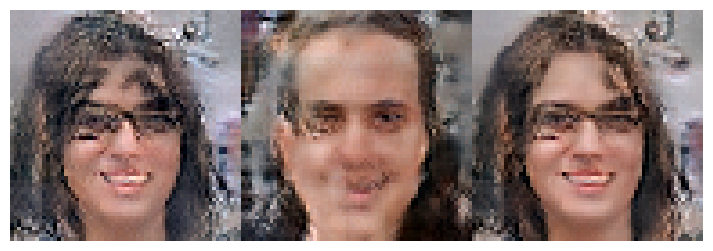

In [ ]:
latent = styleGan.generate_noise(bat_size=2)
styleGan.add_model(64)
#load wieghts
styleGan.load_weights(os.path.join("/content/drive/MyDrive/checkpoints/stylegan_64x64.ckpt"))
tf.random.set_seed(196)
#create mapping net work
w = styleGan.mapping(tf.random.normal((2, styleGan.z_dim)))
images = styleGan({"style_code": w, "noise": latent, "alpha": 1.0})
latent_a = [np.expand_dims(k[0], 0) for k in latent]
#New mixed mapping network is sent to style gan
mix_style = styleGan({"style_code": np.expand_dims(0.4 * w[0] + (1 - 0.4) * w[1], 0), "noise": latent_a})
image_append = np.hstack([images[0], images[1], mix_style[0]])
plt.figure(figsize=(9, 3))
plt.imshow(image_append)
plt.axis("off")

If no of epchs is incresed the resluion of the image incress, due lack of computational power it is resctreced to 5000